# Time Series Analysis of Monterey Airport Weather Data

### Contents

1. [Setup](#setup)

I. ARMA Models
2. [Exploring Stationarity](#stationarity)
3. [Autocorrelation and Partial Autocorrelation](#correlation)
4. [ARMA Modeling](#ar)

II. Exponential Smoothing Models
5. [Naive Season-Trend-Level Decomposition](#naive)
6. [Holt-Winters Seasonal Smoothing](#holt-winters) (a. [Model Comparison](#comparison), b. [2019 Predictions](#forecast))

III. Generalized Additive Models
7. [Facebook Prophet](#prophet)

<a id='setup'></a>

### 1. Setup

In [5]:
from datetime import datetime
from random import seed, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, coint, arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from fbprophet import Prophet

In [6]:
# pandas settings
pd.set_option('display.max_columns', 125) # csv contains 124 columns
pd.set_option('display.max_rows', 4000) # display more rows

In [7]:
df = pd.read_csv('cleaned_df.csv', parse_dates=['datetime'], index_col=['datetime'])
df.head()

,DATE,HourlySkyConditions,HourlyVisibility,HourlyDryBulbTemperature,HourlyWindSpeed,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindSpeed,DailyPrecipitation,HourlyRelativeHumidity,averageObscuration
datetime,,,,,,,,,,,
2009-04-01 00:08:00,2009-04-01T00:08:00,"[{'BKN': SkyCondition(obscuration=7, vertical_...",10.0,52.0,8.0,59.0,49.0,26.0,0.0,77.0,7.00000
2009-04-01 00:50:00,2009-04-01T00:50:00,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,52.0,10.0,59.0,49.0,26.0,0.0,77.0,4.00000
2009-04-01 00:54:00,2009-04-01T00:54:00,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,50.0,9.0,59.0,49.0,26.0,0.0,80.0,4.00000
2009-04-01 01:54:00,2009-04-01T01:54:00,[],9.0,51.0,10.0,59.0,49.0,26.0,0.0,77.0,4.91146
2009-04-01 02:54:00,2009-04-01T02:54:00,[],9.0,50.0,16.0,59.0,49.0,26.0,0.0,80.0,4.91146


## I. ARMA Models

<a id='stationarity'></a>

### 2. Exploring Stationarity

We're primarily modeling the daily maximum temperature, daily average obscuration, and daily humidity variables.

In [8]:
x = df
bool_index = (x.index.hour >= 10) & (x.index.hour <= 16) # consider the clearest and driest part of each day
x = x[bool_index]

obsc = x['averageObscuration'].resample(rule='D').mean().dropna()
hum = x['HourlyRelativeHumidity'].resample(rule='D').mean().dropna()
temp = x['DailyMaximumDryBulbTemperature'].resample(rule='D').last().dropna()

In [9]:
# we need the 2019 data to assess predictions later
obsc_all = obsc[obsc.index.year == 2019]
hum_all = hum[hum.index.year == 2019]
temp_all = temp[temp.index.year == 2019]

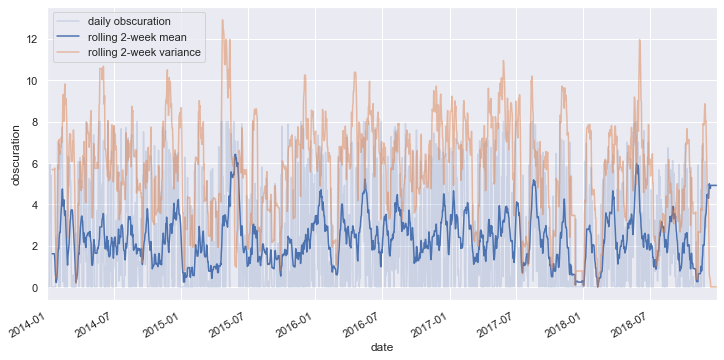

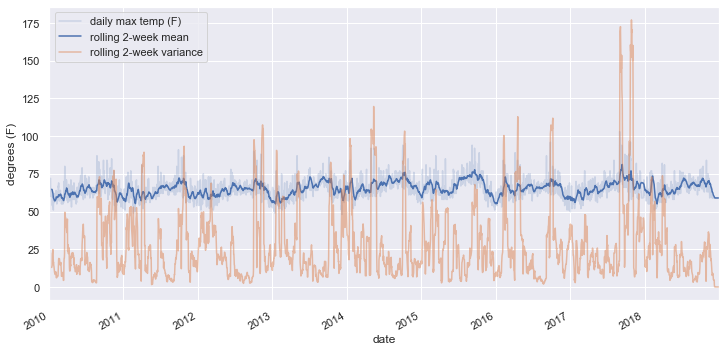

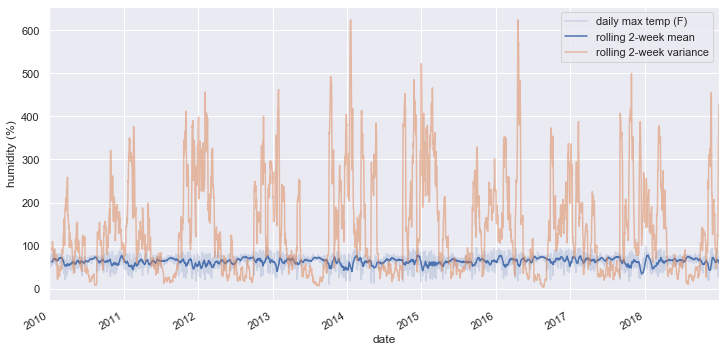

In [17]:
sns.set()

bool_index = (obsc.index.year >= 2014) & (obsc.index.year <= 2018)
obsc = obsc[bool_index]
bool_index = (temp.index.year >= 2010) & (temp.index.year <= 2018)
temp = temp[bool_index]
bool_index = (hum.index.year >= 2010) & (hum.index.year <= 2018)
hum = hum[bool_index]

plt.figure(figsize=(12, 6))
plt.plot(obsc, color='b', alpha=0.2)
obsc.rolling(14).mean().plot()
obsc.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('obscuration')
plt.legend(('daily obscuration', 'rolling 2-week mean', 'rolling 2-week variance'))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(temp, color='b', alpha=0.2)
temp.rolling(14).mean().plot()
temp.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('degrees (F)')
plt.legend(('daily max temp (F)', 'rolling 2-week mean', 'rolling 2-week variance'))

plt.figure(figsize=(12, 6))
plt.plot(hum, color='b', alpha=0.2)
hum.rolling(14).mean().plot()
hum.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('humidity (%)')
plt.legend(('daily max temp (F)', 'rolling 2-week mean', 'rolling 2-week variance'))



plt.show()

Does the Dickey-Fuller test think the daily average obscuration variable acts like a random walk? Its null hypothesis is that the series' properties (mean, variance, autocorrelation) change over time (the series is non-stationary).

In [272]:
results = adfuller(obsc)
print("p-value is:", results[1])

p-value is: 0.0


We can reject the null hypothesis that the daily average obscuration is non-stationary and have evidence to treat the series as stationary.

How about daily maximum temperature?

In [273]:
results = adfuller(temp)
print("p-value is:", results[1])

p-value is: 1.8819053175423097e-06


We can likewise reject the null hypothesis that the Daily Maximum temperature isn't stationary and can treat it as sa stationary series.

How about humidity?

In [274]:
# conduct test
results = adfuller(hum)
print("p-value is:", results[1])

p-value is: 3.488511104743475e-23


The humidity is also likely a stationary time series.

In [275]:
# sanity check: does a random walk have a time dependent structure?

# Generate random residuals
np.random.seed(0)
errors = np.random.normal(0, 1, 1000)

# Create AR(1) (random walk) samples for models with and without unit roots
x_unit_root = [0]
x_no_unit_root = [0]
for i in range(len(errors)):
    x_unit_root.append(x_unit_root[-1] + errors[i])
    x_no_unit_root.append(0.9*x_no_unit_root[-1] + errors[i]) # (0.9 isn't 1, so no unit root)

# Calculate Augmented Dickey-Fuller p-values
adfuller(x_unit_root)[1], adfuller(x_no_unit_root)[1] # good: a random walk is non-stationary

(0.8925193132739655, 3.8562004970537815e-06)

<a id='correlation'></a>

### 3. Autocorrelation and Partial Autocorrelation

The autocorrelation and partial autocorrelation plots of the variables' lag difference series will help suggest the types of ARMA, ARIMA, or SARIMA models that might be appropriate for modeling the time series.

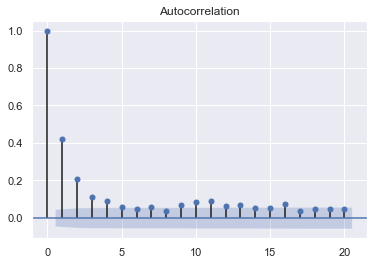

In [276]:
plot_acf(obsc, lags=20)
plt.show()

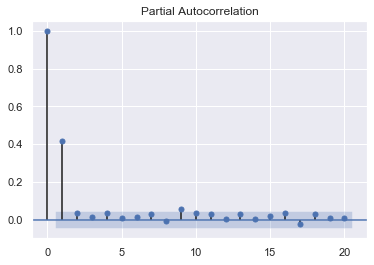

In [277]:
plot_pacf(obsc, lags=20)
plt.show()

Lags 1-4 show significant values in the auto-correlation plot, which suggests an AR model. The values' positive exponential decay suggests a positive value for $\phi$. The partial autocorrelation plot shows a significant value for lag one only, which suggests an AR(1) model.

How about the maximum daily temperature series?

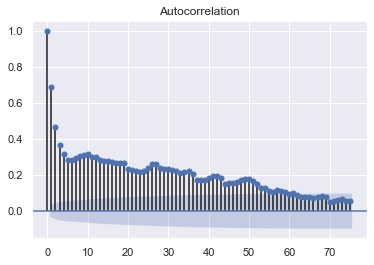

In [278]:
plot_acf(temp, lags=75)
plt.show()

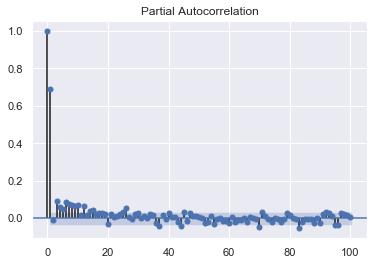

In [279]:
plot_pacf(temp, lags=100)
plt.show()

The temperature variable's partial autocorrelation also suggests an AR(1) model.

And humidity?

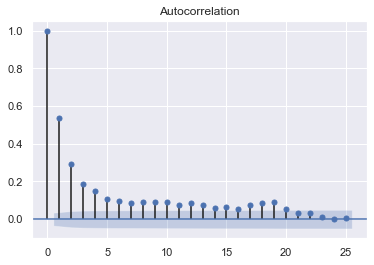

In [280]:
plot_acf(hum, lags=25)
plt.show()

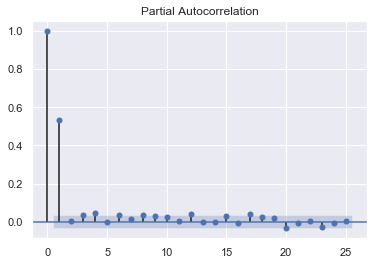

In [281]:
plot_pacf(hum, lags=25)
plt.show()

The humidity variable's partial autocorrelation also suggests an AR(1) model.

We can also use the `arma_order_select_ic` function to try out possible combinations of AR and MA orders (with a default maximum of 4 AR terms and 2 MA terms), to pick the ARMA model with the lowest BIC score:

In [282]:
for series in [temp, obsc, hum]:
    result = arma_order_select_ic(series)['bic_min_order']
    print(str(series.name), ": ", result)

DailyMaximumDryBulbTemperature :  (3, 1)
averageObscuration :  (1, 0)
HourlyRelativeHumidity :  (2, 2)


<a id='ar'></a>

### 4. ARMA Modeling

##### Temperature

In [283]:
# Fit an ARMA model to the first simulated data
model = ARMA(temp, order=(3,1)) # fit to ARMA model
fitted = model.fit()

# Print out summary information on the fit
print(fitted.summary())

# Print out the estimate for the constant and for phi
print("The estimate of phi (and the constant) are:")
print(fitted.params)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                    ARMA Model Results                                    
Dep. Variable:     DailyMaximumDryBulbTemperature   No. Observations:                 3280
Model:                                 ARMA(3, 1)   Log Likelihood               -9736.828
Method:                                   css-mle   S.D. of innovations              4.709
Date:                            Wed, 03 Jul 2019   AIC                          19485.656
Time:                                    19:43:17   BIC                          19522.230
Sample:                                         0   HQIC                         19498.752
                                                                                          
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   65.0788      0.787    

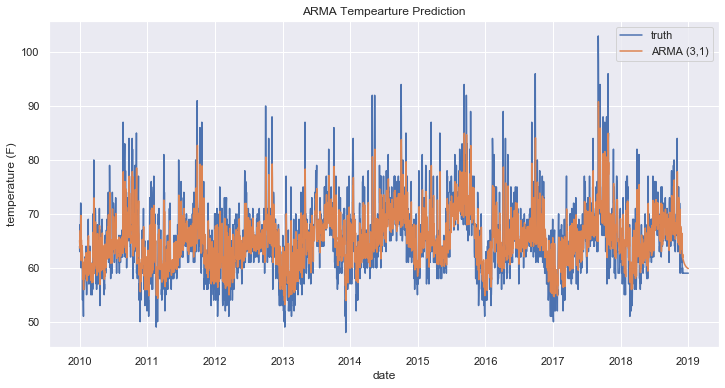

In [289]:
# forecast the past...
cast = fitted.predict(start='01-01-2010', end='12-31-2018')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(temp, label='truth')
plt.plot(cast, label='ARMA (3,1)')
plt.xlabel('date')
plt.ylabel('temperature (F)')
plt.title('ARMA Tempearture Prediction')
plt.legend()
plt.show()

And now we finally use the model to forecast beyond the data. An ARMA forecast will quickly converge to a single value:

In [290]:
forecast = fitted.forecast(31)[0]

How does this model compare to the real January 2019 data? Let's compute the root mean square error (RMSE) and overlay the values:

In [291]:
# get January of 2019 values
x = df
jan_nineteen = x[x.index.year == 2019]
jan_nineteen = jan_nineteen[(jan_nineteen.index.hour >= 10) & (jan_nineteen.index.hour <= 16)]
jan_nineteen = jan_nineteen['DailyMaximumDryBulbTemperature'].resample(rule='D').last().dropna()
jan_nineteen = jan_nineteen[jan_nineteen.index.month == 1]

In [292]:
# calculate error
rmse = np.sqrt(np.mean(np.square(forecast - jan_nineteen.values)))

In [293]:
# give predicted values a datetime index
index = pd.date_range(start='01-01-2019', end='01-31-2019')
jan_predicted = pd.DataFrame(forecast)
jan_predicted = jan_predicted.set_index(index)

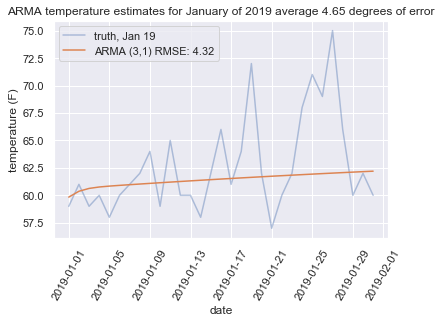

In [294]:
# overlay predicted values with measured values
plt.plot(jan_nineteen, alpha=.4, label='truth, Jan 19')
plt.plot(jan_predicted, label='ARMA (3,1) RMSE: {:0.2f}'.format(rmse))
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('date')
plt.ylabel('temperature (F)')
plt.title('ARMA temperature estimates for January of 2019 average 4.65 degrees of error')
plt.show()

This means predictions will be off by around 25\% of the real value on average.

##### Obscuration

In [309]:
# Fit an ARMA model to the first simulated data
model = ARMA(obsc, order=(1,0)) # fit to ARMA model
fitted = model.fit()

# Print out summary information on the fit
print(fitted.summary())

# Print out the estimate for the constant and for phi
print("The estimate of phi (and the constant) are:")
print(fitted.params)

                              ARMA Model Results                              
Dep. Variable:     averageObscuration   No. Observations:                 1819
Model:                     ARMA(1, 0)   Log Likelihood               -4122.274
Method:                       css-mle   S.D. of innovations              2.333
Date:                Wed, 03 Jul 2019   AIC                           8250.548
Time:                        19:56:44   BIC                           8267.066
Sample:                             0   HQIC                          8256.642
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.3394      0.094     24.872      0.000       2.155       2.524
ar.L1.averageObscuration     0.4186      0.021     19.658      0.000       0.377       0.

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


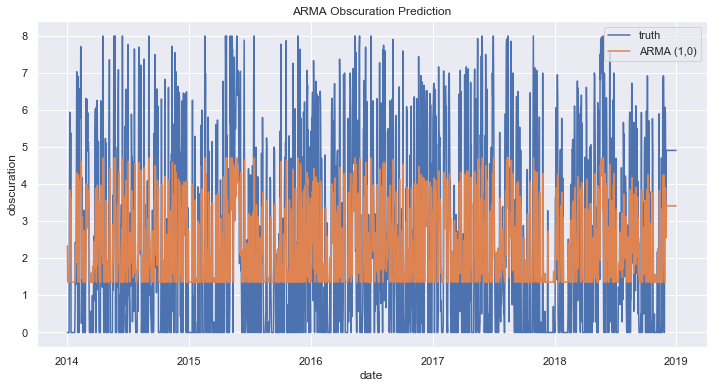

In [310]:
# forecast the past...
cast = fitted.predict(start='01-01-2014', end='12-31-2018')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(obsc, label='truth')
plt.plot(cast, label= 'ARMA (1,0)')
plt.xlabel('date')
plt.ylabel('obscuration')
plt.title('ARMA Obscuration Prediction')
plt.legend()
plt.show()
plt.show()

And now we finally use the model to forecast beyond the data. An ARMA forecast will quickly converge to a single value:

In [311]:
forecast = fitted.forecast(31)[0]

How does this model compare to the real January 2019 data? Let's compute the root mean square error (RMSE) and overlay the values:

In [312]:
# get January of 2019 values
x = df
jan_nineteen = x[x.index.year == 2019]
jan_nineteen = jan_nineteen[(jan_nineteen.index.hour >= 10) & (jan_nineteen.index.hour <= 16)]
jan_nineteen = jan_nineteen['averageObscuration'].resample(rule='D').last().dropna()
jan_nineteen = jan_nineteen[jan_nineteen.index.month == 1]

In [313]:
# calculate error
rmse = np.sqrt(np.mean(np.square(forecast - jan_nineteen.values)))

In [314]:
# give predicted values a datetime index
index = pd.date_range(start='01-01-2019', end='01-31-2019')
jan_predicted = pd.DataFrame(forecast)
jan_predicted = jan_predicted.set_index(index)

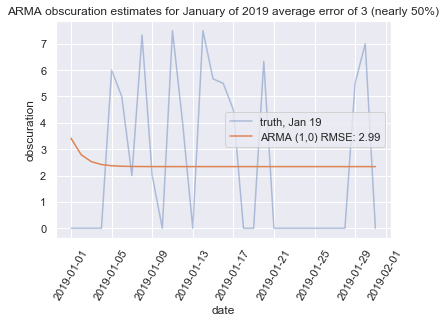

In [315]:
# overlay predicted values with measured values
plt.plot(jan_nineteen, alpha=.4, label='truth, Jan 19')
plt.plot(jan_predicted, label='ARMA (1,0) RMSE: {:0.2f}'.format(rmse))
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('date')
plt.ylabel('obscuration')
plt.title('ARMA obscuration estimates for January of 2019 average error of 3 (nearly 50%)')
plt.show()

This means predictions will be off by around 50 \% of the real value on average.

##### Humidity

In [316]:
# Fit an ARMA model to the first simulated data
model = ARMA(hum, order=(2, 2)) # fit to ARMA model
fitted = model.fit()

# Print out summary information on the fit
print(fitted.summary())

# Print out the estimate for the constant and for phi
print("The estimate of phi (and the constant) are:")
print(fitted.params)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                ARMA Model Results                                
Dep. Variable:     HourlyRelativeHumidity   No. Observations:                 3280
Model:                         ARMA(2, 2)   Log Likelihood              -12561.610
Method:                           css-mle   S.D. of innovations             11.142
Date:                    Wed, 03 Jul 2019   AIC                          25135.221
Time:                            19:57:17   BIC                          25171.794
Sample:                                 0   HQIC                         25148.317
                                                                                  
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           63.5041      0.667     95.243      0.000      62.197      64.811
ar.L1.HourlyRelativeHumidity     1.3828      

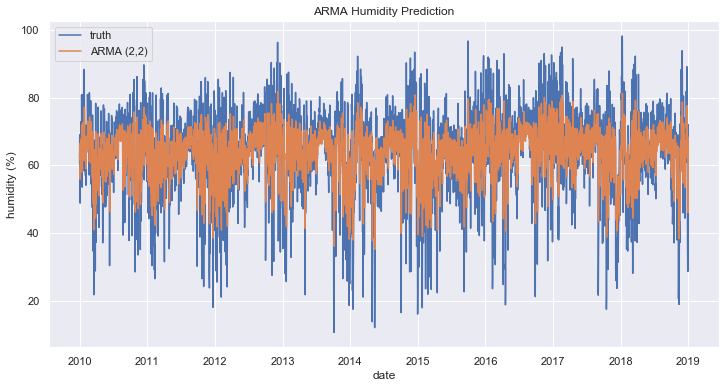

In [319]:
# forecast the past...
cast = fitted.predict(start='01-01-2010', end='12-31-2018')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(hum, label='truth')
plt.plot(cast, label='ARMA (2,2)')
plt.xlabel('date')
plt.ylabel('humidity (%)')
plt.title('ARMA Humidity Prediction')
plt.legend()
plt.show()
plt.show()

And now we finally use the model to forecast beyond the data. An ARMA forecast will quickly converge to a single value:

In [320]:
forecast = fitted.forecast(31)[0]

How does this model compare to the real January 2019 data? Let's compute the root mean square error (RMSE) and overlay the values:

In [321]:
# get January of 2019 values
x = df
jan_nineteen = x[x.index.year == 2019]
jan_nineteen = jan_nineteen[(jan_nineteen.index.hour >= 10) & (jan_nineteen.index.hour <= 16)]
jan_nineteen = jan_nineteen['HourlyRelativeHumidity'].resample(rule='D').mean().dropna()
jan_nineteen = jan_nineteen[jan_nineteen.index.month == 1]

In [322]:
# calculate error
rmse = np.sqrt(np.mean(np.square(forecast - jan_nineteen.values)))

In [323]:
# give predicted values a datetime index
index = pd.date_range(start='01-01-2019', end='01-31-2019')
jan_predicted = pd.DataFrame(forecast)
jan_predicted = jan_predicted.set_index(index)

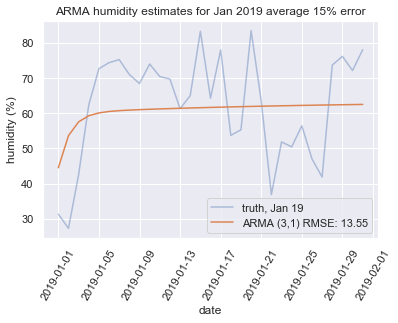

In [324]:
# overlay predicted values with measured values
plt.plot(jan_nineteen, alpha=.4, label='truth, Jan 19')
plt.plot(jan_predicted, label='ARMA (3,1) RMSE: {:0.2f}'.format(rmse))
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('date')
plt.ylabel('humidity (%)')
plt.title('ARMA humidity estimates for Jan 2019 average 15% error')
plt.show()

15\% humidity off in a 50\% humidity range means the predictions are on average around 30\% wrong.

## II. Exponential Smoothing Models

<a id='naive'></a>

### 5. Naive Season-Trend-Level Decomposition

Before applying more sophisticated techniques, the first approach will use a simple moving average technique.

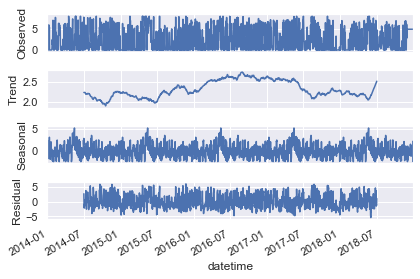

In [325]:
results = seasonal_decompose(obsc, model='additive', freq=365)
results.plot()
plt.show()

This approach separates out stationary trend, seasonal, and residual components.

In [327]:
df_results = adfuller(results.trend.dropna())
print("trend df p-value is:", df_results[1]) # trend isn't stationary (it trends)

df_results = adfuller(results.seasonal.dropna())
print("seasonal df p-value is:", df_results[1]) # seasonality is

df_results = adfuller(results.resid.dropna())
print("residuals p-value is:", df_results[1]) # so are residuals

trend df p-value is: 0.4488899725806956
seasonal df p-value is: 2.7805536590827702e-11
residuals p-value is: 0.0


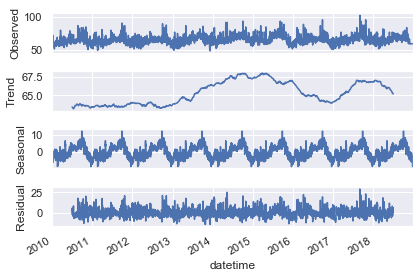

In [329]:
results = seasonal_decompose(temp, model='additive', freq=365)
results.plot()
plt.show()

In [330]:
df_results = adfuller(results.trend.dropna())
print("trend df p-value is:", df_results[1]) # trend isn't stationary (it trends)

df_results = adfuller(results.seasonal.dropna())
print("seasonal df p-value is:", df_results[1]) # seasonality is

df_results = adfuller(results.resid.dropna())
print("residuals p-value is:", df_results[1]) # so are residuals

trend df p-value is: 0.5280017871852764
seasonal df p-value is: 0.0001072283921320691
residuals p-value is: 0.0


<a id='holt-winters'></a>

### 6. Holt-Winters Seasonal Smoothing

<a id='comparison'></a>
#### 6a. Model Comparison

Next, we fit a Holt-Winters exponential smoothing model to the temperature data. We will use the Akaike Information Criterion to assess performance, and we will plot 2018 predictions over 2018's real values.

In [331]:
# separate data into train and test sets
train = temp[:-365]
test = temp.iloc[-365:]

In [332]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)
model3 = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [333]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
fit2 = model2.fit()
cast2 = fit2.forecast(365)
fit3 = model3.fit()
cast3 = fit3.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.

In [334]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))
sse3 = np.sqrt(np.mean(np.square(test.values - cast3.values)))

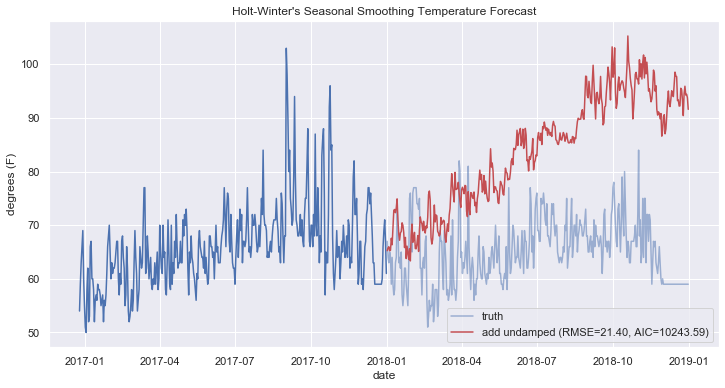

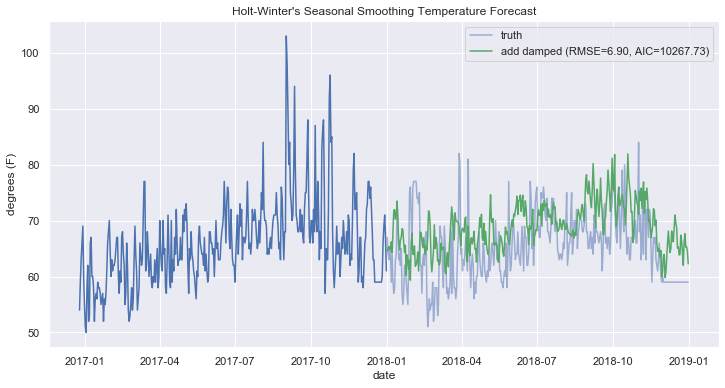

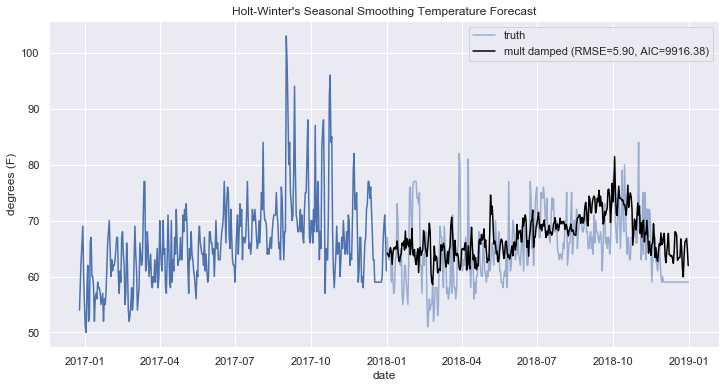

In [335]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast3, color='black', label="mult damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse3, fit3.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

The undamped additive model goes off the rails, and both damped models perform better. [As predicted by Hyndman and Athanasopoulos](https://otexts.com/fpp2/holt-winters.html), the model with damped trend and multiplicative seasonality performs the best by both error and AIC measures.

We repeat the same process for the obscuration data.

In [336]:
# separate data into train and test sets
train = obsc.iloc[:-365]
test = obsc.iloc[-365:]

In [337]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [338]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
cast1 = cast1 - cast1.min()

fit2 = model2.fit()
cast2 = fit2.forecast(365)
cast2 = cast2 - cast2.min()

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [339]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))

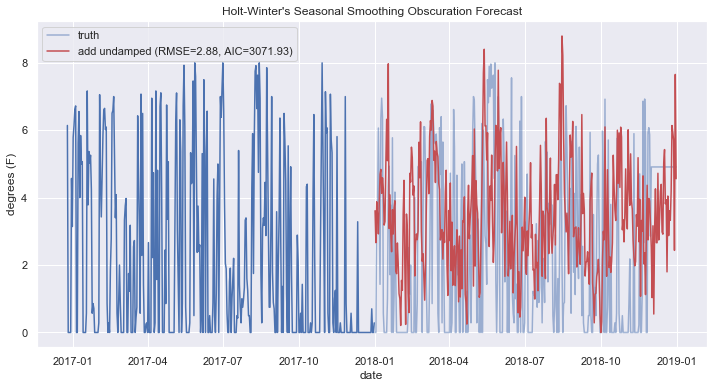

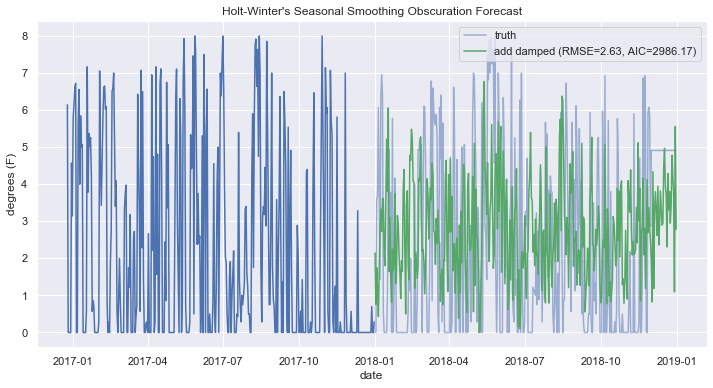

In [340]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Obscuration Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Obscuration Forecast");
plt.show()

For obscuration data, the performance difference between damped and undamped additive models  is much more ambiguous: the undamped model yielded less error, while the damped model yielded a lower AIC score. (All forecast values have been shifted up by their minimum value to avoid negative values.)

And we fit the same model to the humidity data:

In [341]:
# separate data into train and test sets
train = hum[:-365]
test = hum.iloc[-365:]

In [342]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)
model3 = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [343]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
fit2 = model2.fit()
cast2 = fit2.forecast(365)
fit3 = model3.fit()
cast3 = fit3.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.

In [344]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))
sse3 = np.sqrt(np.mean(np.square(test.values - cast3.values)))

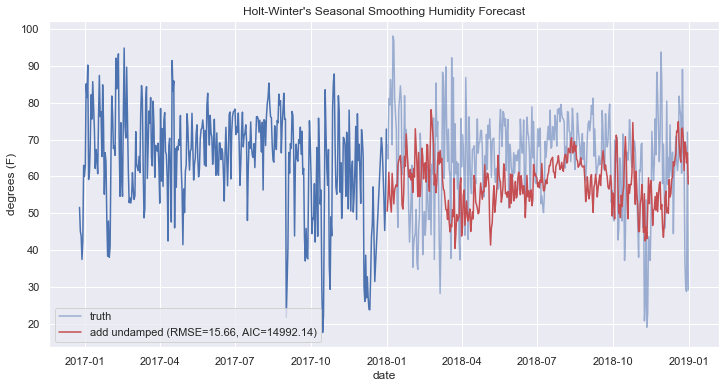

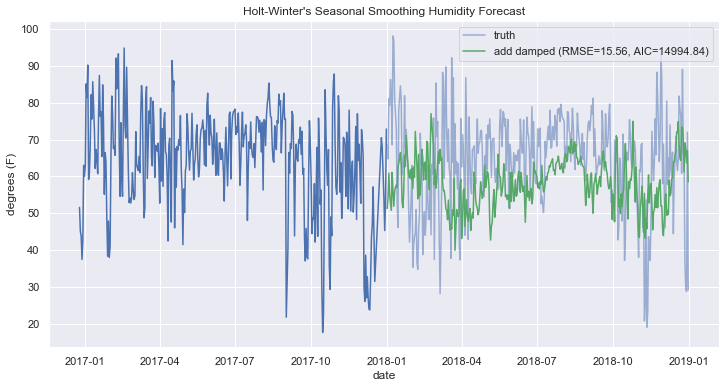

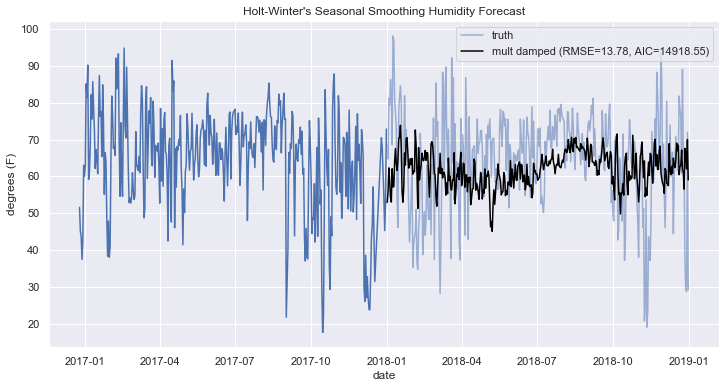

In [345]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast3, color='black', label="mult damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse3, fit3.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

In the case of the humidity data, the damped trend with additive trend and seasonality performs best by both error and AIC measures.

<a id='forecast'></a>
#### 6b. 2019 Model Predictions

In [346]:
# calculate index for use in all predictions
forecast_index = pd.date_range(start='01-01-2019', end='12-31-2019')

A damped, additive trend and multiplicative seaonality model predicts 2019 temperature data:

In [347]:
# set training data
train = temp

In [348]:
# initialize models
temp_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [349]:
# fit models to data
fit_temp = model3.fit()
temp_cast = fit_temp.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


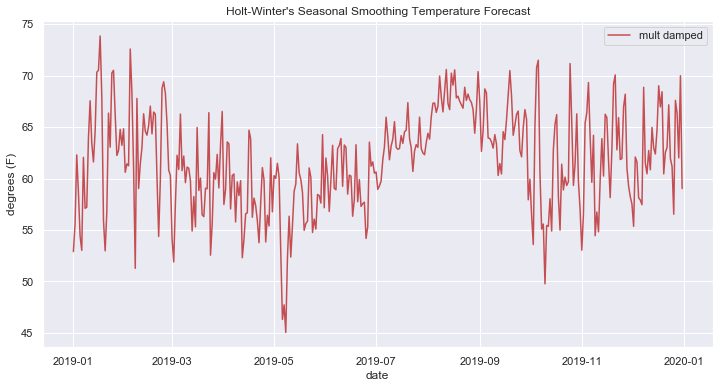

In [350]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(forecast_index, temp_cast, color='r', label="mult damped".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

A damped, additive trend and additive seaonality model predicts 2019 obscuration data:

In [351]:
# set training data
train = obsc

In [352]:
# initialize model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [353]:
# fit models to data
obsc_fit = model.fit()
obsc_cast = obsc_fit.forecast(365)
obsc_cast = obsc_cast - obsc_cast.min()

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


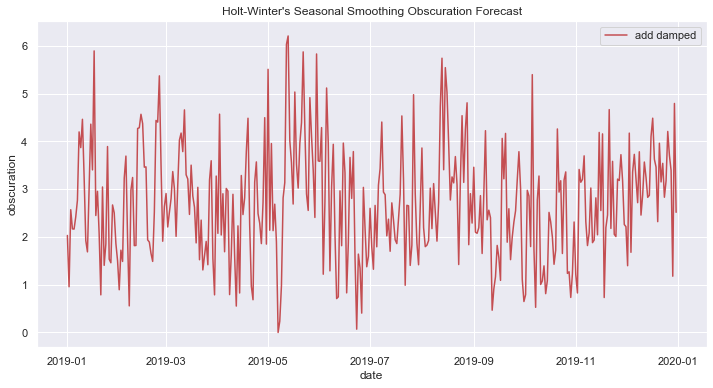

In [354]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(forecast_index, obsc_cast, color='r', label="add damped".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('obscuration')
ax.set_title("Holt-Winter's Seasonal Smoothing Obscuration Forecast");
plt.show()

A damped, additive trend and additive seaonality model predicts 2019 humidity data:

In [355]:
# set the training data
train = hum

In [356]:
# initialize models
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [357]:
# fit models to data
fit = model.fit()
hum_cast = fit.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


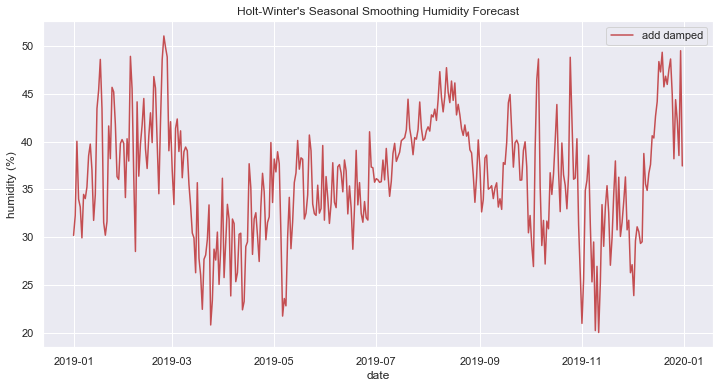

In [358]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(forecast_index, hum_cast, color='r', label="add damped");
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('humidity (%)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

<a id='prophet'></a>
### 7. Facebook Prophet

Facebook's open-source Prophet forecasting tool is a generalized additive model that captures two hierachically seasonal components through Fourier modeling and a trend component using Bayesian inference on smoothing priors. Details [can be found here](https://peerj.com/preprints/3190/).

In [139]:
# make dataframes fbprophet likes
def make_prophet_dataframe_from_series(series):
    frame = pd.DataFrame(series).reset_index()
    frame.columns = ['ds', 'y']
    return frame

##### Temperature

In [140]:
# make prophet frames
fb_temp = make_prophet_dataframe_from_series(temp)
fb_temp.tail()

,ds,y
3275,2018-12-27,59.0
3276,2018-12-28,59.0
3277,2018-12-29,59.0
3278,2018-12-30,59.0
3279,2018-12-31,59.0


In [141]:
# fit the model
m = Prophet()
m.fit(fb_temp)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [142]:
# make future column
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3640,2019-12-27
3641,2019-12-28
3642,2019-12-29
3643,2019-12-30
3644,2019-12-31


In [143]:
# predict
temp_forecast = m.predict(future)
temp_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3640,2019-12-27,61.021124,53.784638,68.518011
3641,2019-12-28,61.058185,53.900629,68.626621
3642,2019-12-29,60.985157,53.982501,68.185354
3643,2019-12-30,61.103092,53.581407,68.235560
3644,2019-12-31,61.330493,54.125660,68.580220


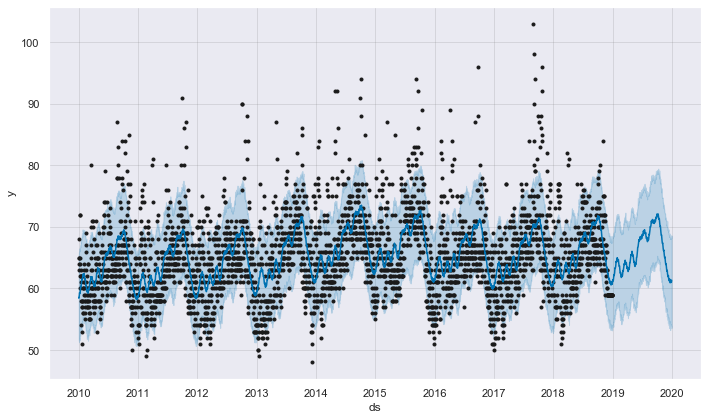

In [144]:
# plot predictions
fig1 = m.plot(temp_forecast)

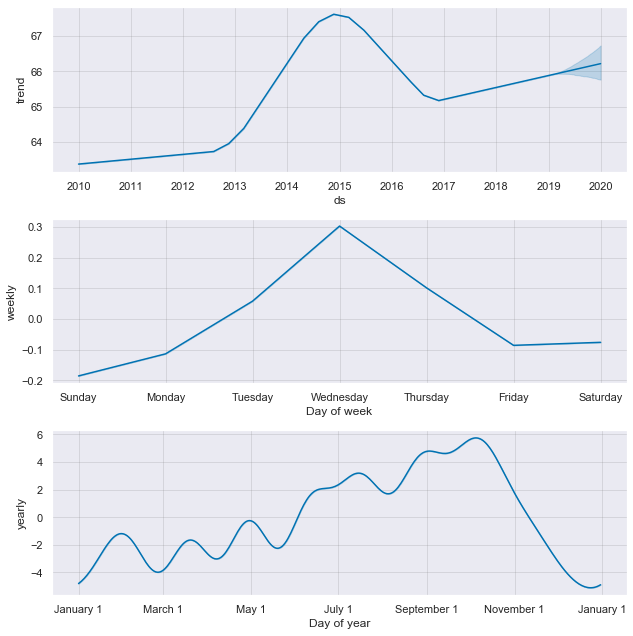

In [145]:
# plot model components
fig2 = m.plot_components(temp_forecast)

##### Obscuration

In [146]:
# make prophet frames
fb_obsc = make_prophet_dataframe_from_series(obsc)
fb_obsc.tail()

,ds,y
1814,2018-12-27,4.91146
1815,2018-12-28,4.91146
1816,2018-12-29,4.91146
1817,2018-12-30,4.91146
1818,2018-12-31,4.91146


In [147]:
# fit the model
m = Prophet()
m.fit(fb_obsc)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [148]:
# make future column
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2179,2019-12-27
2180,2019-12-28
2181,2019-12-29
2182,2019-12-30
2183,2019-12-31


In [149]:
# predict
obsc_forecast = m.predict(future)
obsc_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2179,2019-12-27,3.136435,0.035086,6.396066
2180,2019-12-28,3.245902,0.055232,6.344792
2181,2019-12-29,3.112395,-0.303804,6.309925
2182,2019-12-30,3.195186,0.050476,6.302576
2183,2019-12-31,2.836476,-0.323144,6.090992


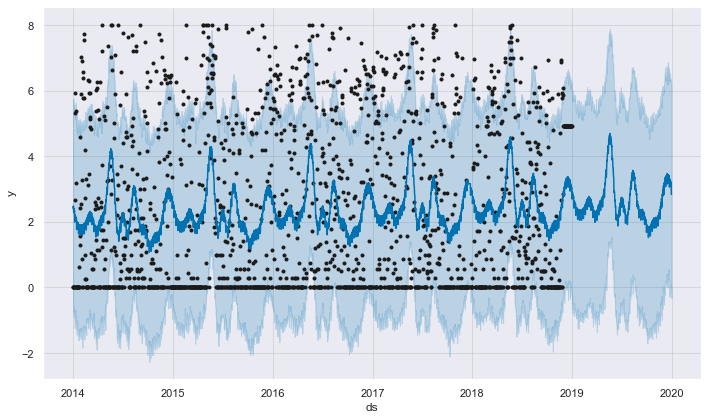

In [150]:
# plot predictions
fig1 = m.plot(obsc_forecast)

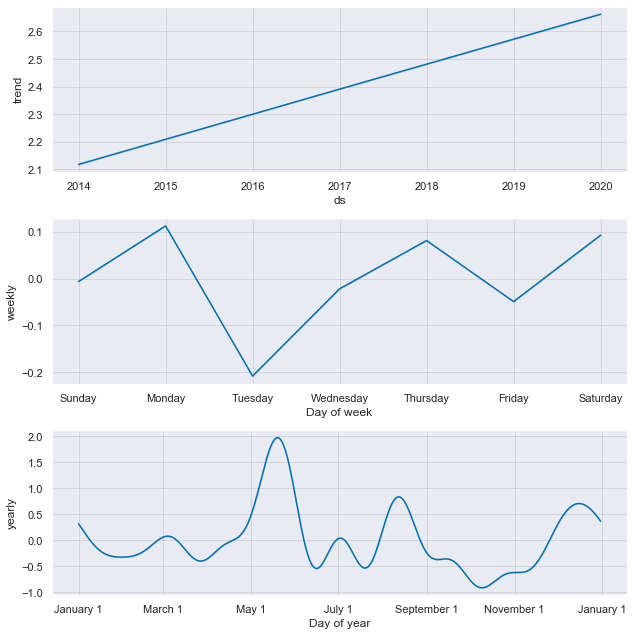

In [151]:
# plot model components
fig2 = m.plot_components(obsc_forecast)

##### Humidity

In [152]:
# make prophet frames
fb_hum = make_prophet_dataframe_from_series(hum)
fb_hum.tail()

,ds,y
3275,2018-12-27,36.714286
3276,2018-12-28,29.285714
3277,2018-12-29,28.714286
3278,2018-12-30,72.000000
3279,2018-12-31,29.142857


In [153]:
# fit the model
m = Prophet()
m.fit(fb_hum)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [154]:
# make future column
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3640,2019-12-27
3641,2019-12-28
3642,2019-12-29
3643,2019-12-30
3644,2019-12-31


In [155]:
# predict
hum_forecast = m.predict(future)
hum_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3640,2019-12-27,59.002216,42.225497,75.746077
3641,2019-12-28,58.976680,42.608785,74.775363
3642,2019-12-29,58.815097,41.561250,76.076791
3643,2019-12-30,59.140106,42.475000,76.263902
3644,2019-12-31,58.640828,43.268612,74.678885


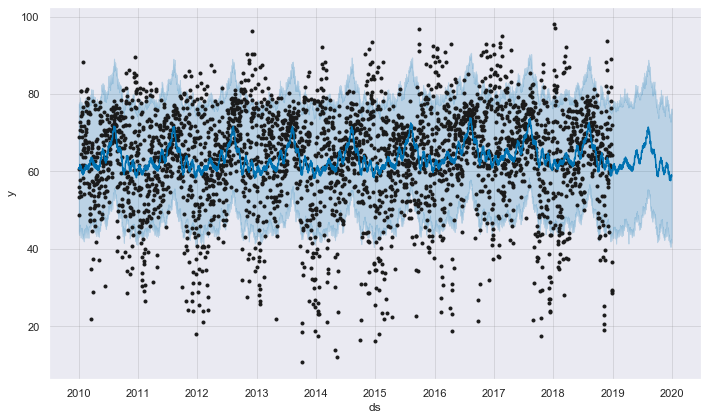

In [156]:
# plot predictions
fig1 = m.plot(hum_forecast)

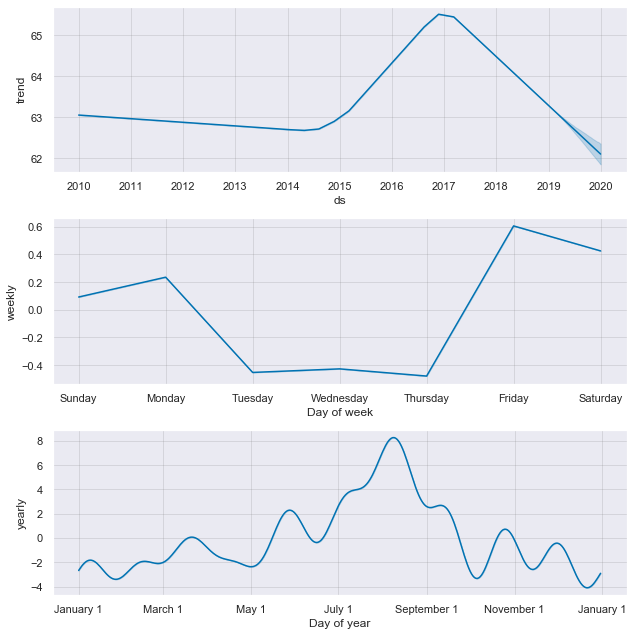

In [157]:
# plot model components
fig2 = m.plot_components(hum_forecast)

How do the prophet predictions compare to the first three months of 2019?

In [158]:
# get 2019 values
temp_nineteen = temp_all[temp_all.index.year == 2019]
temp_nineteen
len(obsc_nineteen)

90

In [159]:
# get estimates
guess_df = pd.DataFrame(temp_forecast['yhat'][:90])
i = pd.date_range(start='01/01/19', end='03/31/19')
guess_df = guess_df.set_index(i)

In [160]:
# calculate error
temp_rmse = np.sqrt(np.mean(np.square(guess_df.values - temp_nineteen.values)))
temp_rmse

5.693763973980777

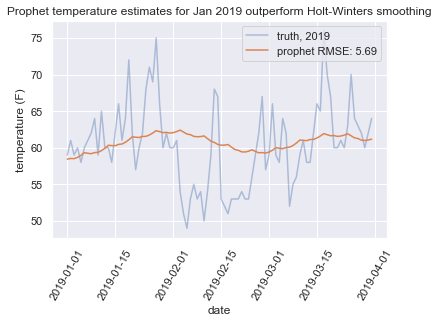

In [161]:
# overlay predicted values with measured values
plt.plot(temp_nineteen, alpha=.4, label='truth, 2019')
plt.plot(guess_df, label='prophet RMSE: {:0.2f}'.format(temp_rmse))
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('date')
plt.ylabel('temperature (F)')
plt.title('Prophet temperature estimates for Jan 2019 outperform Holt-Winters smoothing')
plt.show()

In [171]:
# get 2019 values
obsc_nineteen = obsc_all[obsc_all.index.year == 2019]
obsc_nineteen += np.min(obsc_nineteen)
len(obsc_nineteen)

90

In [172]:
# get estimates
guess_df = pd.DataFrame(obsc_forecast['yhat'][:90])
i = pd.date_range(start='01/01/19', end='03/31/19')
guess_df = guess_df.set_index(i)

In [173]:
# calculate error
obsc_rmse = np.sqrt(np.mean(np.square(guess_df.values - obsc_nineteen.values)))
obsc_rmse

2.692371232072787

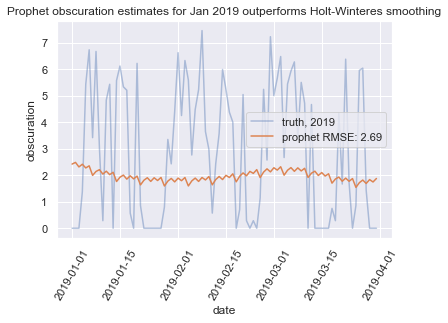

In [174]:
# overlay predicted values with measured values
plt.plot(obsc_nineteen, alpha=.4, label='truth, 2019')
plt.plot(guess_df, label='prophet RMSE: {:0.2f}'.format(obsc_rmse))
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('date')
plt.ylabel('obscuration')
plt.title('Prophet obscuration estimates for Jan 2019 outperforms Holt-Winteres smoothing')
plt.show()

In [166]:
# get 2019 values
hum_nineteen = hum_all[temp_all.index.year == 2019]
len(temp_nineteen)

90

In [167]:
# get estimates
guess_df = pd.DataFrame(hum_forecast['yhat'][:90])
i = pd.date_range(start='01/01/19', end='03/31/19')
guess_df = guess_df.set_index(i)

In [168]:
# calculate error
rmse = np.sqrt(np.mean(np.square(guess_df.values - hum_nineteen.values)))
rmse

12.98746527763348

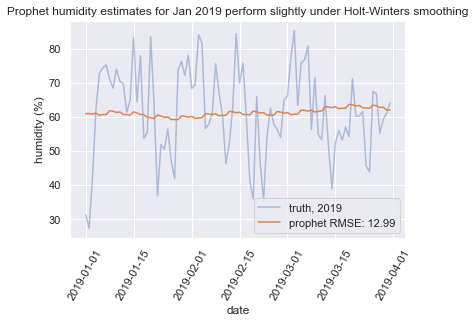

In [169]:
# overlay predicted values with measured values
plt.plot(hum_nineteen, alpha=.4, label='truth, 2019')
plt.plot(guess_df, label='prophet RMSE: {:0.2f}'.format(rmse))
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('date')
plt.ylabel('humidity (%)')
plt.title('Prophet humidity estimates for Jan 2019 perform slightly under Holt-Winters smoothing')
plt.show()